In [1]:
import os, cv2, shutil
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
import os
from collections import Counter

# Update this if needed
LABEL_DIR = r"E:\Fabric Defect Detection\fabric_dataset\labels"

# To hold all class ids
all_class_ids = []

# Traverse through train, val, test
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(LABEL_DIR, split)
    for filename in os.listdir(split_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(split_dir, filename), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 0:
                        class_id = parts[0]
                        all_class_ids.append(class_id)

# Count class frequencies
class_counts = Counter(all_class_ids)

# Optional: class names mapping (if known)
class_names = {
    '0': 'hole',
    '1': 'knot',
    '2': 'stain'
}

# Print results
print("\n📦 Unique Classes Found:")
for class_id, count in class_counts.items():
    name = class_names.get(class_id, "Unknown")
    print(f"Class ID {class_id} → {name}: {count} instances")

print("\nTotal unique class IDs:", len(class_counts))



📦 Unique Classes Found:
Class ID 0 → hole: 187 instances
Class ID 1 → knot: 135 instances
Class ID 2 → stain: 487 instances

Total unique class IDs: 3


In [3]:
# 📁 CONFIG
BASE_DIR = r"E:\Fabric Defect Detection\fabric_dataset"
IMAGE_DIR = os.path.join(BASE_DIR, "images/train")
LABEL_DIR = os.path.join(BASE_DIR, "labels/train")
CSV_PATH = os.path.join(BASE_DIR, "E:/Fabric Defect Detection/fabric_dataset/fabric_types.csv")
METADATA_DIR = os.path.join(BASE_DIR, "metadata/train")

CLASSES = ['hole', 'knot', 'stain']
NUM_CLASSES = len(CLASSES)

fabric_df = pd.read_csv(CSV_PATH)
unique_fabrics = sorted(fabric_df["Fabric_Type"].unique())
fabric_to_id = {name: i for i, name in enumerate(unique_fabrics)}
id_to_fabric = {v: k for k, v in fabric_to_id.items()}
NUM_FABRIC_TYPES = len(unique_fabrics)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 🔄 AUGMENTATION FUNCTION
def augment_image(image):
    aug = []
    aug.append(cv2.flip(image, 1))
    aug.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
    aug.append(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
    alpha = np.random.uniform(0.8, 1.2)
    beta = np.random.randint(-20, 20)
    bright_contrast = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    aug.append(bright_contrast)
    return aug


In [5]:
# 📂 DATASET CLASS
class IntegratedFabricDataset(Dataset):
    def __init__(self, image_dir, label_dir, fabric_df, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.fabric_df = fabric_df
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        base = Path(fname).stem
        img_path = os.path.join(self.image_dir, fname)
        lbl_path = os.path.join(self.label_dir, base + ".txt")

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        boxes, labels = [], []
        if os.path.exists(lbl_path):
            with open(lbl_path, "r") as f:
                for line in f.readlines():
                    cid, xc, yc, bw, bh = map(float, line.strip().split())
                    labels.append(int(cid))
                    x1 = (xc - bw / 2) * w
                    y1 = (yc - bh / 2) * h
                    x2 = (xc + bw / 2) * w
                    y2 = (yc + bh / 2) * h
                    boxes.append([x1, y1, x2, y2])

        # Fabric type from CSV
        csv_row = self.fabric_df[self.fabric_df["Image"].str.contains(fname)]
        if not csv_row.empty:
            fabric_name = csv_row.iloc[0]["Fabric_Type"]
            fabric_label = fabric_to_id[fabric_name]
        else:
            fabric_label = 0  # default if missing

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(boxes), torch.tensor(labels), torch.tensor(fabric_label), fname


In [6]:
# 🔁 COLLATE
def custom_collate(batch):
    imgs, bboxes, defects, fabric_labels, fnames = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    return imgs, bboxes, defects, torch.tensor(fabric_labels), fnames

# 🔧 TRANSFORMS
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [7]:
# 🧠 COMBINED MODEL
class CombinedClassifier(nn.Module):
    def __init__(self, num_defect_classes, num_fabric_classes):
        super().__init__()
        base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base.children())[:-1])
        feat_dim = base.fc.in_features

        self.defect_head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_defect_classes)
        )
        self.fabric_head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_fabric_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        defect_logits = self.defect_head(x)
        fabric_logits = self.fabric_head(x)
        return defect_logits, fabric_logits

In [8]:
# 📈 TRAINING
dataset = IntegratedFabricDataset(IMAGE_DIR, LABEL_DIR, fabric_df, transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)

model = CombinedClassifier(len(CLASSES), NUM_FABRIC_TYPES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 15
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct_defect, correct_fabric, total = 0, 0, 0

    for imgs, _, defect_labels_list, fabric_labels, _ in train_loader:
        imgs = imgs.to(device)
        fabric_labels = fabric_labels.to(device)
        defect_labels = torch.tensor([labels[0] if len(labels) > 0 else 0 for labels in defect_labels_list], dtype=torch.long).to(device)

        pred_defect, pred_fabric = model(imgs)
        loss_defect = criterion(pred_defect, defect_labels)
        loss_fabric = criterion(pred_fabric, fabric_labels)
        loss = loss_defect + loss_fabric

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred_def = torch.max(pred_defect, 1)
        _, pred_fab = torch.max(pred_fabric, 1)
        correct_defect += (pred_def == defect_labels).sum().item()
        correct_fabric += (pred_fab == fabric_labels).sum().item()
        total += imgs.size(0)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}, "
          f"Defect Acc: {100 * correct_defect / total:.2f}%, "
          f"Fabric Acc: {100 * correct_fabric / total:.2f}%")


Epoch 1/15, Loss: 82.3284, Defect Acc: 86.38%, Fabric Acc: 99.34%
Epoch 2/15, Loss: 22.4726, Defect Acc: 97.34%, Fabric Acc: 100.00%
Epoch 3/15, Loss: 16.8821, Defect Acc: 96.84%, Fabric Acc: 100.00%
Epoch 4/15, Loss: 12.1586, Defect Acc: 97.84%, Fabric Acc: 100.00%
Epoch 5/15, Loss: 21.2775, Defect Acc: 96.51%, Fabric Acc: 100.00%
Epoch 6/15, Loss: 13.3182, Defect Acc: 97.67%, Fabric Acc: 100.00%
Epoch 7/15, Loss: 8.1097, Defect Acc: 98.67%, Fabric Acc: 100.00%
Epoch 8/15, Loss: 3.5597, Defect Acc: 99.50%, Fabric Acc: 100.00%
Epoch 9/15, Loss: 4.5392, Defect Acc: 99.34%, Fabric Acc: 100.00%
Epoch 10/15, Loss: 4.6677, Defect Acc: 99.17%, Fabric Acc: 100.00%
Epoch 11/15, Loss: 10.9075, Defect Acc: 97.84%, Fabric Acc: 100.00%
Epoch 12/15, Loss: 4.0921, Defect Acc: 99.17%, Fabric Acc: 100.00%
Epoch 13/15, Loss: 10.4173, Defect Acc: 98.17%, Fabric Acc: 100.00%
Epoch 14/15, Loss: 3.1137, Defect Acc: 99.50%, Fabric Acc: 100.00%
Epoch 15/15, Loss: 5.9601, Defect Acc: 99.17%, Fabric Acc: 100.0

In [9]:
import os

# Create directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Now save the model
MODEL_PATH = "models/combined_fabric_defect_model.pt"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to models/combined_fabric_defect_model.pt


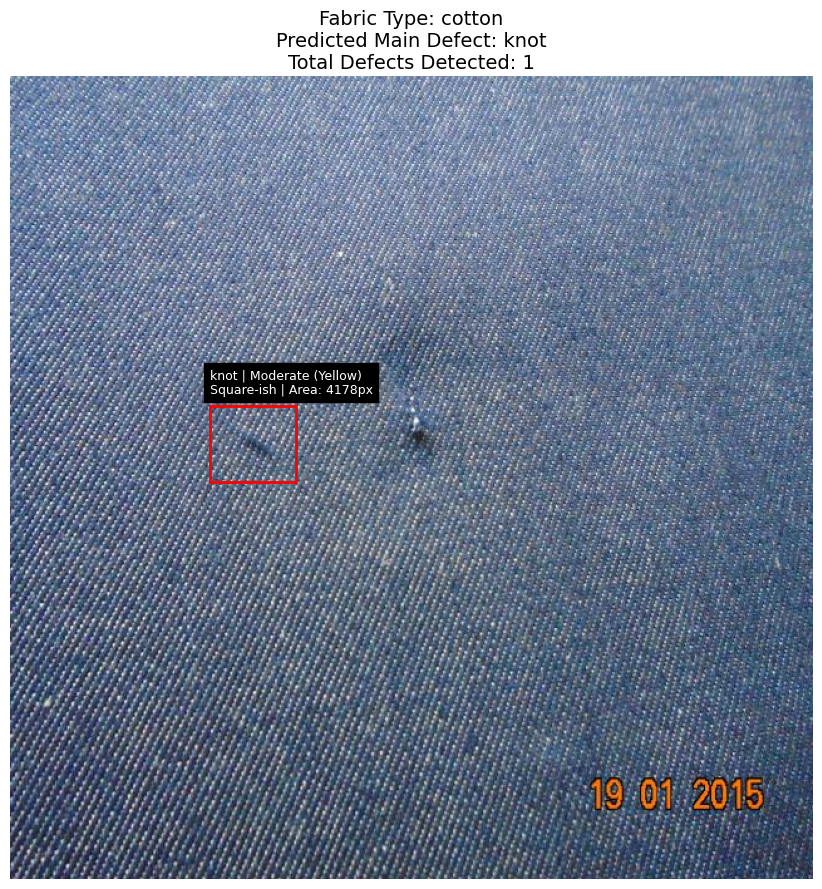

In [10]:
def compute_shape_descriptors(x1, y1, x2, y2, image_w, image_h):
    w, h = x2 - x1, y2 - y1
    area = w * h
    rel_area = area / (image_w * image_h)
    aspect_ratio = w / h if h != 0 else 0

    # Shape label
    if aspect_ratio < 0.5:
        shape = "Tall & Narrow"
    elif aspect_ratio > 2.0:
        shape = "Wide & Short"
    else:
        shape = "Square-ish"

    return area, rel_area, aspect_ratio, shape

def estimate_severity(rel_area):
    if rel_area < 0.01:
        return 'Minor', '(Green)'
    elif rel_area < 0.03:
        return 'Moderate', '(Yellow)'
    else:
        return 'Severe', '(Red)'


def draw_prediction(image_path, label_path, model):
    model.eval()
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_tensor = transform(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        defect_out, fabric_out = model(input_tensor)
        _, pred_defect = torch.max(defect_out, 1)
        _, pred_fabric = torch.max(fabric_out, 1)
        pred_defect_name = CLASSES[pred_defect.item()]
        pred_fabric_name = id_to_fabric[pred_fabric.item()]

    h, w = img.shape[:2]
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_rgb)

    defect_count = 0

    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                cid, xc, yc, bw, bh = map(float, line.strip().split())
                x1 = (xc - bw/2) * w
                y1 = (yc - bh/2) * h
                x2 = (xc + bw/2) * w
                y2 = (yc + bh/2) * h

                area, rel_area, ar, shape = compute_shape_descriptors(x1, y1, x2, y2, w, h)
                severity, icon = estimate_severity(rel_area)

                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                         linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

                desc = f"{CLASSES[int(cid)]} | {severity} {icon}\n{shape} | Area: {area:.0f}px"
                ax.text(x1, y1 - 10, desc, fontsize=9, color='white', backgroundcolor='black')

                defect_count += 1

    title = (
    f"Fabric Type: {pred_fabric_name}\n"
    f"Predicted Main Defect: {pred_defect_name}\n"
    f"Total Defects Detected: {defect_count}"

    )
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# 🧪 TEST
test_img = "fabric_dataset/images/train/485_knot.jpg"
test_lbl = "fabric_dataset/labels/train/485_knot.txt"
draw_prediction(test_img, test_lbl, model)